<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-\amily:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Data Leakage
              
</p>
</div>

Data Science Cohort Live NYC June 2023
<p>Phase 3</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>

## Obejective
- Explain data leakage
- **Explain** the bias-variance tradeoff and the correlative notions of underfit and overfit models
- Explain the notion of "validation data"

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

#### Data Leakage
- When information not generally available/used at prediction time contaminates the modeling training process.

<center><img src = "Images/despair.jpg" width = 350 /></center>
<center> The despair of realizing you have a data leak.</center>

Leads to overconfident estimates of model performance during the validation and testing phases.

- Bad performance after model deployment in production.


<center><img src = "Images/despair.jpg" width = 350 /></center>
<center> My overlords are upset.</center>

<center><img src = "Images/despair.jpg" width = 350 /></center>
<center> I have spent all night trying to find the data leak.</center>

<center><img src = "Images/despair.jpg" width = 350 /></center>
<center> What is the nature of my leak?</center>

<center><img src = "Images/despair.jpg" width = 350 /></center>
<center> Where is it??</center>

Diagnosing a data leak can be subtle business:
- Understanding different types of leak
- Where in the process they can be accidentally introduced.

#### Training leakage

Fitting and applying transformations **before** train-test(hold out) splitting.

<img src = "Images/training_testing.png" width = 500 />

- Why is this bad?

Applying transformation to training set:
- contains information from test set (contained in fitted attributes of Transformer)

- Contaminated training set.
- Model has inadvertently trained on information you are trying to predict.

#### You can introduce it by accident on really innocuous steps.

In [ ]:
import pandas as pd
titanic_df = pd.read_csv('Data/titanic.csv').drop(columns = ['Cabin'])
titanic_df.info()

Let's impute those NaNs in age with the mean.

In [ ]:
# impute with the mean
titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df['Age'].mean())
titanic_df.info()

Bam. You just introduced data leakage.
- imputed with statistics of entire dataset before train-test split.
- Statistics of train in test and vice-versa.
- Whether impact is significant will depend on data and model.

#### Leakage between train and true test can be a truly costly mistake:
- You'll only figure it out after you've deployed
- Made suboptimal predictions:
    - incorrectly recommending inventory changes to increase sales
    - or *much* worse.


#### Other types of data leakage: Feature leakage

Dependent on how the data/features were collected.

<img src = "Images\data_leakage_predcontam.png" width = 800/>

- Predicting whether we should approve a loan or not.
- Have database of current lendees.

- Features include:
    - Salary information at time of loan approval
    - Pre-loan bankruptcy history
    - FICO score
    - Listed occupation
    - Monthly interest payments.
    - Bank balance across accounts.
    

**What's the problem here?**

Possibly conflating information from *after* prediction with properties before prediction.
- Features from **after** prediction potentially affected by target.
- Our target is now leaking into the way we trained our model.
- Features *before* and *after* approval may not be drawn from same distribution.

**These sources of feature leakage can be very subtle**
- Understanding of the data collection process and data definitions is critical here.

**Case Study**

Predict sale price of a given home.

- Size of the house (in square meters)
- Average sales price of homes in the same neighborhood
- Latitude and longitude of the house
- Whether the house has a basement

Is there a source of potential data leakage? Explain.

Depends on whether the average includes the sales prices including given sale or before it.

**Another Case Study**

Want to predict rate of infection during surgery based on:
- patient specific factors (immuno-history, etc.)
- environmental factors (hospital cleanliness inspections, etc.)

Your idea: include surgeon as a factor.

1. Take all surgeries by each surgeon and calculate the infection rate among those surgeons.
2. For each patient in the data, find out who the surgeon was and plug in that surgeon's average infection rate as a feature.

Potentially introduces both target leakage and train-test leak:

- Target leakage: if given patient's outcome contributes to the infection rate for his surgeon. 
- Using target to calculate feature.
- Then using this feature to predict target.

Can avoid by using:
- Surgeon's infection rate for only surgeries before the patient we are predicting for.
- Tricky, for sure.

Train-test contamination problem if you calculate this using all surgeries a surgeon performed
- Including those from the test-set. 

Are you tearing your hair out? Good. You now understand data leakage.

## Preprocessing

In general all preprocessing steps are subject to the same dangers here. Consider the preprocessing step of one-hot-encoding:

In [2]:
gun_poll = pd.read_csv('data/guns-polls.csv')

In [3]:
gun_poll.head()

,Question,Start,End,Pollster,Population,Support,Republican Support,Democratic Support,URL
0,age-21,2/20/18,2/23/18,CNN/SSRS,Registered Voters,72,61,86,http://cdn.cnn.com/cnn/2018/images/02/25/rel3a...
1,age-21,2/27/18,2/28/18,NPR/Ipsos,Adults,82,72,92,https://www.ipsos.com/en-us/npripsos-poll-majo...
2,age-21,3/1/18,3/4/18,Rasmussen,Adults,67,59,76,http://www.rasmussenreports.com/public_content...
3,age-21,2/22/18,2/26/18,Harris Interactive,Registered Voters,84,77,92,http://thehill.com/opinion/civil-rights/375993...
4,age-21,3/3/18,3/5/18,Quinnipiac,Registered Voters,78,63,93,https://poll.qu.edu/national/release-detail?Re...


In [4]:
gun_poll['Pollster'].value_counts()

YouGov                 12
Morning Consult        11
Quinnipiac              8
NPR/Ipsos               7
CNN/SSRS                5
CBS News                4
Rasmussen               2
Suffolk                 2
Harris Interactive      1
YouGov/Huffpost         1
SurveyMonkey            1
ABC/Washington Post     1
Harvard/Harris          1
Marist                  1
Name: Pollster, dtype: int64

Now if I were to fit a one-hot encoder to the whole `Pollster` column here, the encoder would learn all the categories. But I need to prepare myself for the real-world possibility that unfamiliar categories may show up in future records. Let's explore this.

In [5]:
# First I'll do a split
X_train, X_test = train_test_split(gun_poll, random_state=42)

Let's suppose now that I fit a `OneHotEncoder` to the `Pollster` column in my training data.

#### Exercise
Fit an encoder to the `Pollster` column of the training data and then check to see which categories are represented.

In [21]:
to_be_dummied = X_train[['Pollster']]
ohe = OneHotEncoder()
ohe.fit(to_be_dummied)
ohe.get_feature_names_out()

array(['Pollster_ABC/Washington Post', 'Pollster_CBS News',
       'Pollster_CNN/SSRS', 'Pollster_Marist', 'Pollster_Morning Consult',
       'Pollster_NPR/Ipsos', 'Pollster_Quinnipiac', 'Pollster_Rasmussen',
       'Pollster_Suffolk', 'Pollster_YouGov', 'Pollster_YouGov/Huffpost'],
      dtype=object)

<details>
    <summary>Answer</summary>

``` python
to_be_dummied = X_train[['Pollster']]
ohe = OneHotEncoder()
ohe.fit(to_be_dummied)
## So what categories do we have?
ohe.get_feature_names_out()
```
</details>

We'll want to transform both train and test after we've fitted the encoder to the train.

In [22]:
test_to_be_dummied = X_test[['Pollster']]

ohe.transform(to_get_dummies)
ohe.transform(test_to_be_dummied)

ValueError: Found unknown categories ['Harris Interactive', 'Harvard/Harris', 'SurveyMonkey'] in column 0 during transform

There are categories in the testing data that don't appear in the training data! What should 
we do about that?

### Approaches
- **Strategy 1**: Divide up the categories proportionally when we do our train_test_split. If we're using `sklearn`'s tool, that means taking advantage of the `stratify` parameter:

In [23]:
new_X_train, new_X_test = train_test_split(gun_poll,
                                           stratify=gun_poll['Pollster'],
                                           random_state=42)

Unfortunately, in this case, we can't use this since some categories have only a single member.

- **Strategy 2**: Drop the categories with very few representatives.

In the present case, let's try dropping the single-member categories.

In [24]:
vc = gun_poll['Pollster'].value_counts()
vc_only_1 = vc[vc == 1]
bad_cols = vc_only_1.index
vc

YouGov             12
Morning Consult    11
Quinnipiac          8
NPR/Ipsos           7
CNN/SSRS            5
CBS News            4
Rasmussen           2
Suffolk             2
Name: Pollster, dtype: int64

In [25]:
bad_cols

Index([], dtype='object')

In [26]:
gun_poll['Pollster'] = gun_poll['Pollster'].map(lambda x: np.nan if x in bad_cols else x)
gun_poll = gun_poll.dropna()

C:\Users\somdd\AppData\Local\Temp\ipykernel_33644\2463301282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gun_poll['Pollster'] = gun_poll['Pollster'].map(lambda x: np.nan if x in bad_cols else x)


In [27]:
gun_poll['Pollster'].value_counts()

YouGov             12
Morning Consult    11
Quinnipiac          8
NPR/Ipsos           7
CNN/SSRS            5
CBS News            4
Rasmussen           2
Suffolk             2
Name: Pollster, dtype: int64

We could now split this carefully so that new categories don't show up in the testing data. In fact, now we can try the stratified split:

In [17]:
X_train3, X_test3 = train_test_split(gun_poll,
                                     stratify=gun_poll['Pollster'],
                                     test_size=0.3,
                                     random_state=42)

In [18]:
X_train3['Pollster'].value_counts()

Morning Consult    8
YouGov             8
Quinnipiac         6
NPR/Ipsos          5
CNN/SSRS           3
CBS News           3
Rasmussen          1
Suffolk            1
Name: Pollster, dtype: int64

In [19]:
X_test3['Pollster'].value_counts()

YouGov             4
Morning Consult    3
CNN/SSRS           2
Quinnipiac         2
NPR/Ipsos          2
CBS News           1
Rasmussen          1
Suffolk            1
Name: Pollster, dtype: int64

Now every category that appears in the test data appears also in the training data.

- **Strategy 3**: Adjust the settings on the one-hot-encoder.

For `sklearn`'s tool, we'll tweak the `handle_unknown` parameter:

#### Exericse
Fit a new encoder to our training data column that won't break when we try to use it to transform the test data. And then use the encoder to transform both train and test.

In [28]:
ohe2 = OneHotEncoder(handle_unknown='ignore')
ohe2.fit(to_be_dummied)
test_to_be_dummied = X_test[['Pollster']]
ohe2.transform(to_be_dummied)
ohe2.transform(test_to_be_dummied)

<15x11 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>

<details>
    <summary>Answer</summary>
    
```python
ohe2 = OneHotEncoder(handle_unknown='ignore')
ohe2.fit(to_be_dummied)
test_to_be_dummied = X_test[['Pollster']]
ohe2.transform(to_be_dummied)
ohe2.transform(test_to_be_dummied)
```
</details>

In [29]:
t = pd.DataFrame(ohe2.transform(test_to_be_dummied).todense(), columns = ohe2.get_feature_names_out())
t.head()

,Pollster_ABC/Washington Post,Pollster_CBS News,Pollster_CNN/SSRS,Pollster_Marist,Pollster_Morning Consult,Pollster_NPR/Ipsos,Pollster_Quinnipiac,Pollster_Rasmussen,Pollster_Suffolk,Pollster_YouGov,Pollster_YouGov/Huffpost
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# The Bias-Variance Tradeoff

We can break up how the model makes mistakes (the error) by saying there are three parts:

- Error inherent in the data (noise): **irreducible error**
- Error from not capturing signal (too simple): **bias**
- Error from "modeling noise", i.e. capturing patterns in the data that don't generalize well (too complex): **variance**

### Bias

**High-bias** algorithms tend to be less complex, with simple or rigid underlying structure.

![](images/noisy-sine-linear.png)

+ They train models that are consistent, but inaccurate on average.
+ These include linear or parametric algorithms such as regression and naive Bayes.
+ The following sorts of difficulties could lead to high bias:
  - We did not include the correct predictors
  - We did not take interactions into account
  - We missed a non-linear (polynomial) relationship

      
High-bias models are generally **underfit**: The models have not picked up enough of the signal in the data. And so even though they may be consistent, they don't perform particularly well on the initial data, and so they will be consistently inaccurate.

### Variance

On the other hand, **high-variance** algorithms tend to be more complex, with flexible underlying structure.

<img src = "images/noisy-sine-decision-tree.png"  width = 800/>


+ They train models that are accurate on average, but inconsistent.
+ These include non-linear or non-parametric algorithms such as decision trees and nearest-neighbor models.
+ The following sorts of difficulties could lead to high variance:
  - We included an unreasonably large number of predictors;
  - We created new features by squaring and cubing each feature.

High variance models are **overfit**: The models have picked up on the noise as well as the signal in the data. And so even though they may perform well on the initial data, they will be inconsistently accurate on new data.

### Balancing Bias and Variance

While we build our models, we have to keep this relationship in mind.  If we build complex models, we risk overfitting our models.  Their predictions will vary greatly when introduced to new data.  If our models are too simple, the predictions as a whole will be inaccurate.   

![](images/noisy-sine-third-order-polynomial.png)

Bias: 
- when model not complex enough
- feature space not adequately rich enough to explain target

Variance: 

- model/weights: large fluctuations about true model given different train sets

- High $ \mathrm{Var}[\textbf{w}] $ over realization of training sets

- High fluctuation in MAE over test sets.

The bulls-eye diagrams of fitting model to different training set realizations:
<center><img src = "images/biasvar_bullseye.png" width = 400/></center>

Each dot is a model:
- Bulls-eye: the *true* model (generating mean of $y$ given $X$ in the population) 
- Each dot: models trained on different samples.

**Our goal**: lowering bias and variance in training predictive models

but the two often at odds.

#### Multicollinearity
Have to grapple with these issues when constructing linear models with multicollinear features

We talked about this way back. But how does it increase Var[$\textbf{w}$]?

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

WHO_data = pd.read_csv("data/WHO_life.csv")
X_WHO = WHO_data.drop(columns = ["Life expectancy "])
y = WHO_data["Life expectancy "]

In [31]:
X_WHO.head()

,Country,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,263.0,62,0.01,71.279624,65.0,1154,19.1,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,271.0,64,0.01,73.523582,62.0,492,18.6,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,268.0,66,0.01,73.219243,64.0,430,18.1,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,272.0,69,0.01,78.184215,67.0,2787,17.6,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,275.0,71,0.01,7.097109,68.0,3013,17.2,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Many features from WHO dataset:

Regressing to find weights life expectancy

In [32]:
X_WHO.columns

Index(['Country', 'Year', 'Status', 'Adult Mortality', 'infant deaths',
       'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ',
       'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ',
       ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

But let's take a look at a few of these and their correlations:

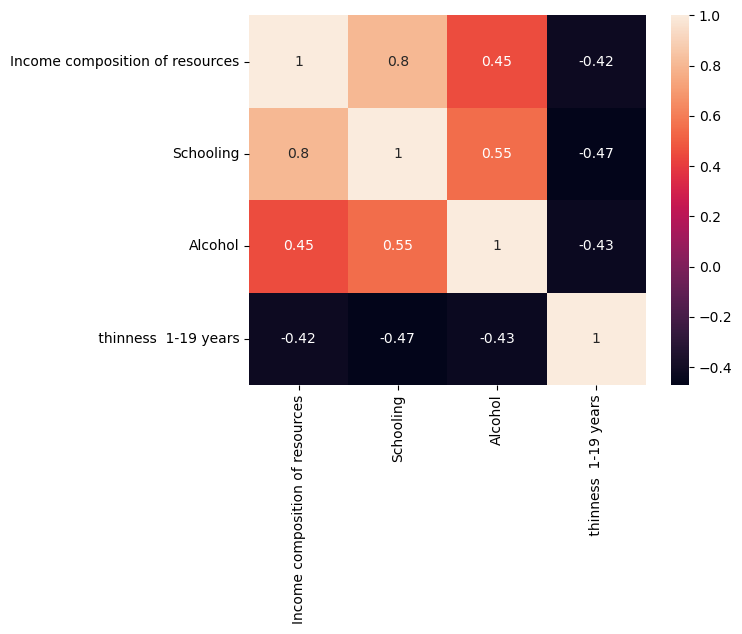

In [35]:
col_selector = ['Income composition of resources', 'Schooling','Alcohol', ' thinness  1-19 years']
subsetX = X_WHO[col_selector]
sns.heatmap(subsetX.corr(), annot = True)
plt.show()

Let's focus on Schooling and income composite resources (ICR):

$$ Life= w_1*Alcohol + w_2*Polio + w_3*Schooling + w_4*Measles + w_5*ICR + ... $$

Correlation is very high!

In [34]:
col_selector = ['Income composition of resources', 'Schooling']
X_WHO[col_selector].corr()

,Income composition of resources,Schooling
Income composition of resources,1.000000,0.800092
Schooling,0.800092,1.000000


Our regression: 
- Y = life expectancy

$$ Y - \sum_{i \neq 3,5} w_i x_i = w_3 Schooling + w_5 ICR $$

- Schooling and ICR highly related:

- Implies that $w_3$ and $w_5$ introduce too much flexibility.
- Maybe could fit almost as well with just $w_3$.

- $w_3$ and $w_5$ are floppy and can become big in either direction to fit data.
- Var[$\textbf{w}$] from $w_3$ and $w_5$ high.

Modeling data by linear model w/ multicollinear features:
- intoduces high weight variance
- unnecessary model complexity

These considerations are all nice and theoretical:
    
- how do we actually assess whether model suffers from bias / variance or both?

#### How to assess model variance: cross-validation

Could get many different training sets:
- Train weights $\textbf{w}$ for each.
- Get variance of $\textbf{w}$ 

Semi-equivalently:
- Test performance of each model on test set.
- Evaluate model performance/variance by looking at average/standard deviation of performance on test set.

Problem: 
- likely don't have this much data available to make enough independent training sets large enough to for each model to train on effectively.

#### Solution: Cross validation

So first we created our train / test split: 

- the **training set** can be used to develop models
- can assess variance of a model and average performance

<img src = "images/traintestsplit.png"  width = 800/>
<center> Splitting up training set </center>

<img src = "Images/crossval.png"  width = 800/>
<center> Splitting up training set </center>

Split up training set into folds:
- Training fold
- Validation fold

- For each iteration:
    - train a model.
    - Test on validation fold. 

Effectively sampling multiple training sets:
- testing each model performance on different **validation set**.
- Good for estimating model performance on average
- Good for estimating model variance as well.


So in the end:
- Performance metrics measured on validation
- We get average performance metric across all the models for each cross validation iteration.
- Get variance of performance metric.

Note: **validation set** is part of training set:
- Not part of true test/hold-out set.

We are often trying out different model types:
- OLS with raw features
- OLS with collinear features dropped
- OLS with polynomial features
- Ridge regressor (will see later)

Idea is that we try out different model types / tune models: 
- assess variance
- assess average performance

**Use train/validation for this**: 
- for each model type: estimate model average performance and variance *across different train/validation realizations*

True and final evaluation:
- Measure performance on tuned model on the test set that has never been seen before.

<img src = "Images/cvtuningflow.png"  width = 800/>
<center> Model comparison/selection using cross-validation </center>
<center> Best model from cross-validation in test phase</center>

Roughly:
- Training data is for building the model;
- Validation data is for *tweaking* the model;
- Testing data is for evaluating the model on unseen data.

- Think of **training** data as what you study for a test
- Think of **validation** data is using a practice test (note sometimes called **dev**)
- Think of **testing** data as what you use to judge the model
    - A **holdout** set is when your test dataset is never used for training (unlike in cross-validation)

Selected best model based on:
- what worked best on the given validation folds.

**Iterative optimization of models based on the train/validation data**

Ultimately: 

- want to evaluate our best model class (found by optimizing over the validation sets) 
- on data that has neither been trained or validated on

![](https://scikit-learn.org/stable/_images/grid_search_workflow.png)
> Image from Scikit-Learn https://scikit-learn.org/stable/modules/cross_validation.html


<img src = "Images/test_phase_afterCV.png"  width = 800/>
<center> Best model from cross-validation in test phase</center>

1. Split data into training data and a holdout test
2. Design a model
3. Evaluate how well it generalizes with **cross-validation** (only training data)
4. Determine if we should adjust model, use cross-validation to evaluate, and repeat
5. After iteratively adjusting your model, do a _final_ evaluation with the holdout test set
6. DON'T TOUCH THE MODEL!!!

Cross validation gives us a way to test statistical robustness of model performance:
- evaluate average performance
- evaluate model variance

But seeing a set of models have high variance:
- How to address this problem found in cross-validation trials?
- i.e., how do we lower the variance?

#### Ways to limit/deal with high variance.

- Get more data. With enough training data, even with floppy weights it'll get it right.

- Yeah, but often not possible/easy to get enough data for this.

- Get rid of columns that exhibit a high degree of collinearity with other columns.

- Yeah, but did we throw out some useful information for prediction? 
- ICR and schooling not the same thing.
- How many of the collinear columns should we throw away? Which ones?

Getting rid of columns like this:
- Can lower variance
- But can also increase bias in an arbitrary, non-optimal way

- Or we could come up with ways to directly limit the variance through the cost function itself.

The hope is that with this method:
- decrease variance
- without increasing bias too much

Doing this in an optimal and principled way.

## Leakage in cross validation

<img src = "Images/crossval.png" width = 500/>

When you pollute your training fold with your validation fold:

- Each cross-validation trial has data leakage.

Validation performance measurements not correct:
- Incorrect estimates of average model performance
- Incorrect estimates of model variance.

Messes up your hyperparameter tuning:
- "Best model": hyperparameter settings with best average model performance
- But it doesn't work well on my test/hold-out set...

## KFold

In [36]:
data = load_diabetes()

print(data.DESCR)

df = pd.concat([pd.DataFrame(data.data, columns=data.feature_names),
               pd.Series(data.target, name='target')], axis=1)

df.head()

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [ ]:
X, y = load_diabetes(return_X_y=True)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=42)

In [ ]:
for train_ind, val_ind in KFold().split(X_train2):
    
    train = X_train2[train_ind, :]
    val = X_train2[val_ind, :]
    
    target_train = y_train2[train_ind]
    target_val = y_train2[val_ind]
    
    ss = StandardScaler().fit(train)
    
    train_scld = ss.transform(train)
    
    val_scld = ss.transform(val)
    
    lr = LinearRegression().fit(train_scld, target_train)
    
    print(lr.coef_[0])